In [1]:
from keras.models import model_from_json, Model
import keras.backend as K

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.metrics import explained_variance_score
from sklearn.utils.multiclass import unique_labels
import sklearn.metrics

Using TensorFlow backend.


# 1. Setup
## 1.1 Load Model
Test the s1p1 (see-1-predict-1) or s1p5 model:

In [ ]:
test_model = "s1p5"

In [2]:
if test_model == "s1p1":
    # ??? = you need to train the model before testing it
    MODEL_DIR = "./best_weights/???/"
    MODEL_NAME = "s1p1_model_???"
elif test_model == "s1p5":
    # 2019_06_25_13_30 = available model for s1p5
    MODEL_DIR = "./best_weights/2019_06_25_13_30/"
    MODEL_NAME = "s1p5_model_2019_06_25_13_30"

# load json and create model
with open(MODEL_DIR + "%s.json" % MODEL_NAME, 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(MODEL_DIR + "%s.h5" % MODEL_NAME)
print("Loaded model from disk")

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 100, 100, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 49, 49, 32)   0           conv_0[0][0]                     
_________________________________________________________________________________________________

In [3]:
IMAGE_SHAPE = (200, 200, 1)
NUM_LABELS = 5
BINS_EDGE = np.load("./data/bins_edge.npy")
NUM_CLASSES = len(BINS_EDGE) - 1  

## 1.2 Load Validation Dataset & Get Model Prediction

In [14]:
# X_val, y_val = gen_classifier_dataset("./s1p10_data/s1p10_CH2_validation.csv", **gen_param)
X_val = np.load('./data/CH2_validation_X.npy')
y_val_arr = np.load('./data/CH2_validation_y.npy')
y_val = [y_val_arr[i, :, :]for i in range(NUM_LABELS)]

#### Adapting dataset to see-1-predict-1 architecture
The data is preprared for see-1-predict-5 architecture, so we have 5 labels for each. 
We will just take the first one:

In [ ]:
if test_model == "s1p1":
    y_train = y_train[0]
    y_val = y_val[0]
    
    # Integer conversion of the keys from char to integers (needed for the s1p1)
    classes_weight = {}
    for k in CLASSES_WEIGHT.keys():
        classes_weight[int(k)] = CLASSES_WEIGHT[k]

In [17]:
# Get model prediction
for i in range(X_val.shape[0]):
    X_val[i, :, :, 0] /= 122.5

mean_X_val = np.mean(X_val, axis=0)
for i in range(X_val.shape[0]):
    X_val[i, :, :, :] -= mean_X_val
    
y_hat = model.predict(X_val, verbose=1)

2021/2021 [==============================] - 3s 1ms/step


# 2. Model Performance
## 2.1 Metrics 
Two metrics are used to access model peformance
* **Root Mean Square Error**
* **Exaplained Variance Score**

In [19]:
def one_hot_to_angle(one_hot_arr):
    """
    Decode 1 one hot encoded vector to get angle
    
    Input:
        one_hot_arr (np.ndarray): shape (1, NUM_CLASSES)
        bins_edge (np.ndarray): shape (1, NUM_CLASSES + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (BINS_EDGE[angle_id] + BINS_EDGE[angle_id + 1]) / 2.
    else:
        return BINS_EDGE[angle_id]

def id_to_angle(one_hot_arr):
    """
    Decode a matrix of one_hot vector (each vector is a row)
    """
    angles = np.zeros(one_hot_arr.shape[0])
    for i in range(len(angles)):
        angles[i] = one_hot_to_angle(one_hot_arr[i, :])
    return angles

In [20]:
def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean(np.square(y_hat - y)))

In [21]:
rmse_seq = []
eva_seq = []

if test_model == "s1p1":
    # Get first angle ID in the sequence
    y_id = y_val
    y_hat_id = y_hat

    # Convert angle ID to angle value
    y_value = id_to_angle(y_id)
    y_hat_value = id_to_angle(y_hat_id)

    # calculate RMSE
    rmse_seq.append(root_mean_squared_error(y_value, y_hat_value))
    eva_seq.append(explained_variance_score(y_value, y_hat_value))
    
if test_model == "s1p5":
    for i in range(NUM_LABELS):
        # Get first angle ID in the sequence
        y_id = y_val[i]
        y_hat_id = y_hat[i]

        # Convert angle ID to angle value
        y_value = id_to_angle(y_id)
        y_hat_value = id_to_angle(y_hat_id)

        # calculate RMSE
        rmse_seq.append(root_mean_squared_error(y_value, y_hat_value))
        eva_seq.append(explained_variance_score(y_value, y_hat_value))

### Baseline from the paper `DroNet: Learning to Fly by Driving`:
**RMSE: 0.109**

**EVA: 0.737**

In [22]:
print("\t\t RMSE \t\t EVA")
for i in range(NUM_LABELS):
    print("Pred %d: \t %.4f \t %.4f" % (i, rmse_seq[i], eva_seq[i]))

		 RMSE 		 EVA
Pred 0: 	 0.1062 	 0.8369
Pred 1: 	 0.1059 	 0.8365
Pred 2: 	 0.1112 	 0.8177
Pred 3: 	 0.1114 	 0.8169
Pred 4: 	 0.1189 	 0.7959


## 2.2 Angle ID distribution

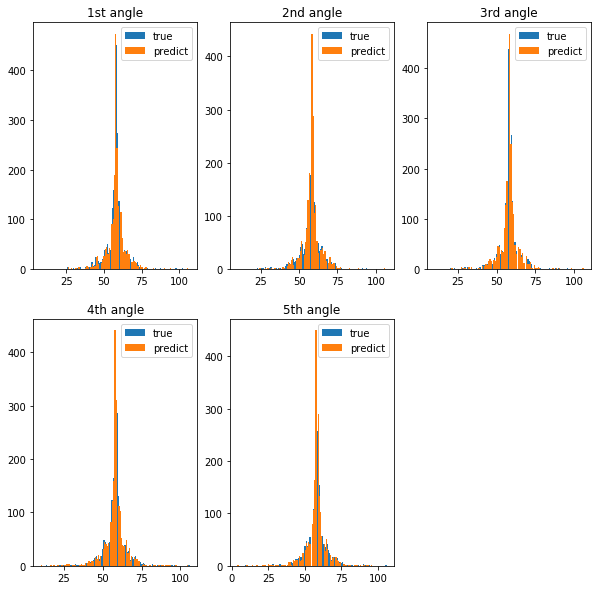

In [23]:
# convert y_val to ID
y_val_id_list = [np.argmax(y_val[j], axis=1) for j in range(NUM_LABELS)]
y_hat_id_list = [np.argmax(y_hat[j], axis=1) for j in range(NUM_LABELS)]

if test_model == "s1p1":
    # Plot angle ID histogram for each prediciton in the sequence
    plt.figure(figsize=(10, 10))
    bins_cnt_val_0, _, _ = plt.hist(y_val_id_list[0], bins=NUM_CLASSES, label="true")
    bins_cnt_hat_0, _, _ = plt.hist(y_hat_id_list[0], bins=NUM_CLASSES, label="predict")
    plt.title("predicted angle")
    
if test_model == "s1p5":
    # Plot angle ID histogram for each prediciton in the sequence
    plt.figure(figsize=(10, 10))
    plt.subplot(231)
    bins_cnt_val_0, _, _ = plt.hist(y_val_id_list[0], bins=NUM_CLASSES, label="true")
    bins_cnt_hat_0, _, _ = plt.hist(y_hat_id_list[0], bins=NUM_CLASSES, label="predict")
    plt.title("1st angle")
    plt.legend(loc='upper right')

    plt.subplot(232)
    bins_cnt_val_1, _, _ = plt.hist(y_val_id_list[1], bins=NUM_CLASSES, label="true")
    bins_cnt_hat_1, _, _ = plt.hist(y_hat_id_list[1], bins=NUM_CLASSES, label="predict")
    plt.title("2nd angle")
    plt.legend(loc='upper right')

    plt.subplot(233)
    bins_cnt_val_2, _, _ = plt.hist(y_val_id_list[2], bins=NUM_CLASSES, label="true")
    bins_cnt_hat_2, _, _ = plt.hist(y_hat_id_list[2], bins=NUM_CLASSES, label="predict")
    plt.title("3rd angle")
    plt.legend(loc='upper right')

    plt.subplot(234)
    bins_cnt_val_3, _, _ = plt.hist(y_val_id_list[3], bins=NUM_CLASSES, label="true")
    bins_cnt_hat_3, _, _ = plt.hist(y_hat_id_list[3], bins=NUM_CLASSES, label="predict")
    plt.title("4th angle")
    plt.legend(loc='upper right')

    plt.subplot(235)
    bins_cnt_val_4, _, _ = plt.hist(y_val_id_list[4], bins=NUM_CLASSES, label="true")
    bins_cnt_hat_4, _, _ = plt.hist(y_hat_id_list[4], bins=NUM_CLASSES, label="predict")
    plt.title("5th angle")
    plt.legend(loc='upper right')

plt.savefig("./images/predicted_angles_distribution.png")
plt.show()

In [24]:
bins_cnt_val = [bins_cnt_val_0, bins_cnt_val_1, bins_cnt_val_2, bins_cnt_val_3, bins_cnt_val_4]
bins_cnt_hat = [bins_cnt_hat_0, bins_cnt_hat_1, bins_cnt_hat_2, bins_cnt_hat_3, bins_cnt_hat_4]
print("Highest bin counts")
print("\t\t True \t Predicted")
for i in range(5):
    print("Predict %d: \t %d \t %d" % (i, np.argmax(bins_cnt_val[i]), np.argmax(bins_cnt_hat[i])))

Highest bin counts
		 True 	 Predicted
Predict 0: 	 57 	 57
Predict 1: 	 56 	 57
Predict 2: 	 55 	 57
Predict 3: 	 57 	 57
Predict 4: 	 60 	 66


In [25]:
print(BINS_EDGE[57], BINS_EDGE[58])

-0.06108659082646417 -0.02618000578657753


# 3. Checkout layers' activation
Only for s1p5 model

In [26]:
if test_model == "s1p5":
    # Define intermediate model to get intermediate layer output
    layer_list = ['feature_map_0', 'feature_map_1', 'feature_map_2']
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_list])


In [27]:
if test_model == "s1p5":
    # randomly choose 10 images from validation set to visualize layers' activation 
    X_vis = X_val[np.random.randint(0, high=X_val.shape[0], size=10), ...]

    # Get intermediate output with test images 
    intermediate_output = intermediate_layer_model.predict(X_vis, verbose=1)

10/10 [==============================] - 0s 18ms/step


In [28]:
if test_model == "s1p5":
    print("type of intermediate_output: ", type(intermediate_output))
    print("len intermediate_output: ", len(intermediate_output))
    print("shape of first feature map:", intermediate_output[0].shape)

type of intermediate_output:  <class 'list'>
len intermediate_output:  3
shape of first feature map: (10, 49, 49, 32)


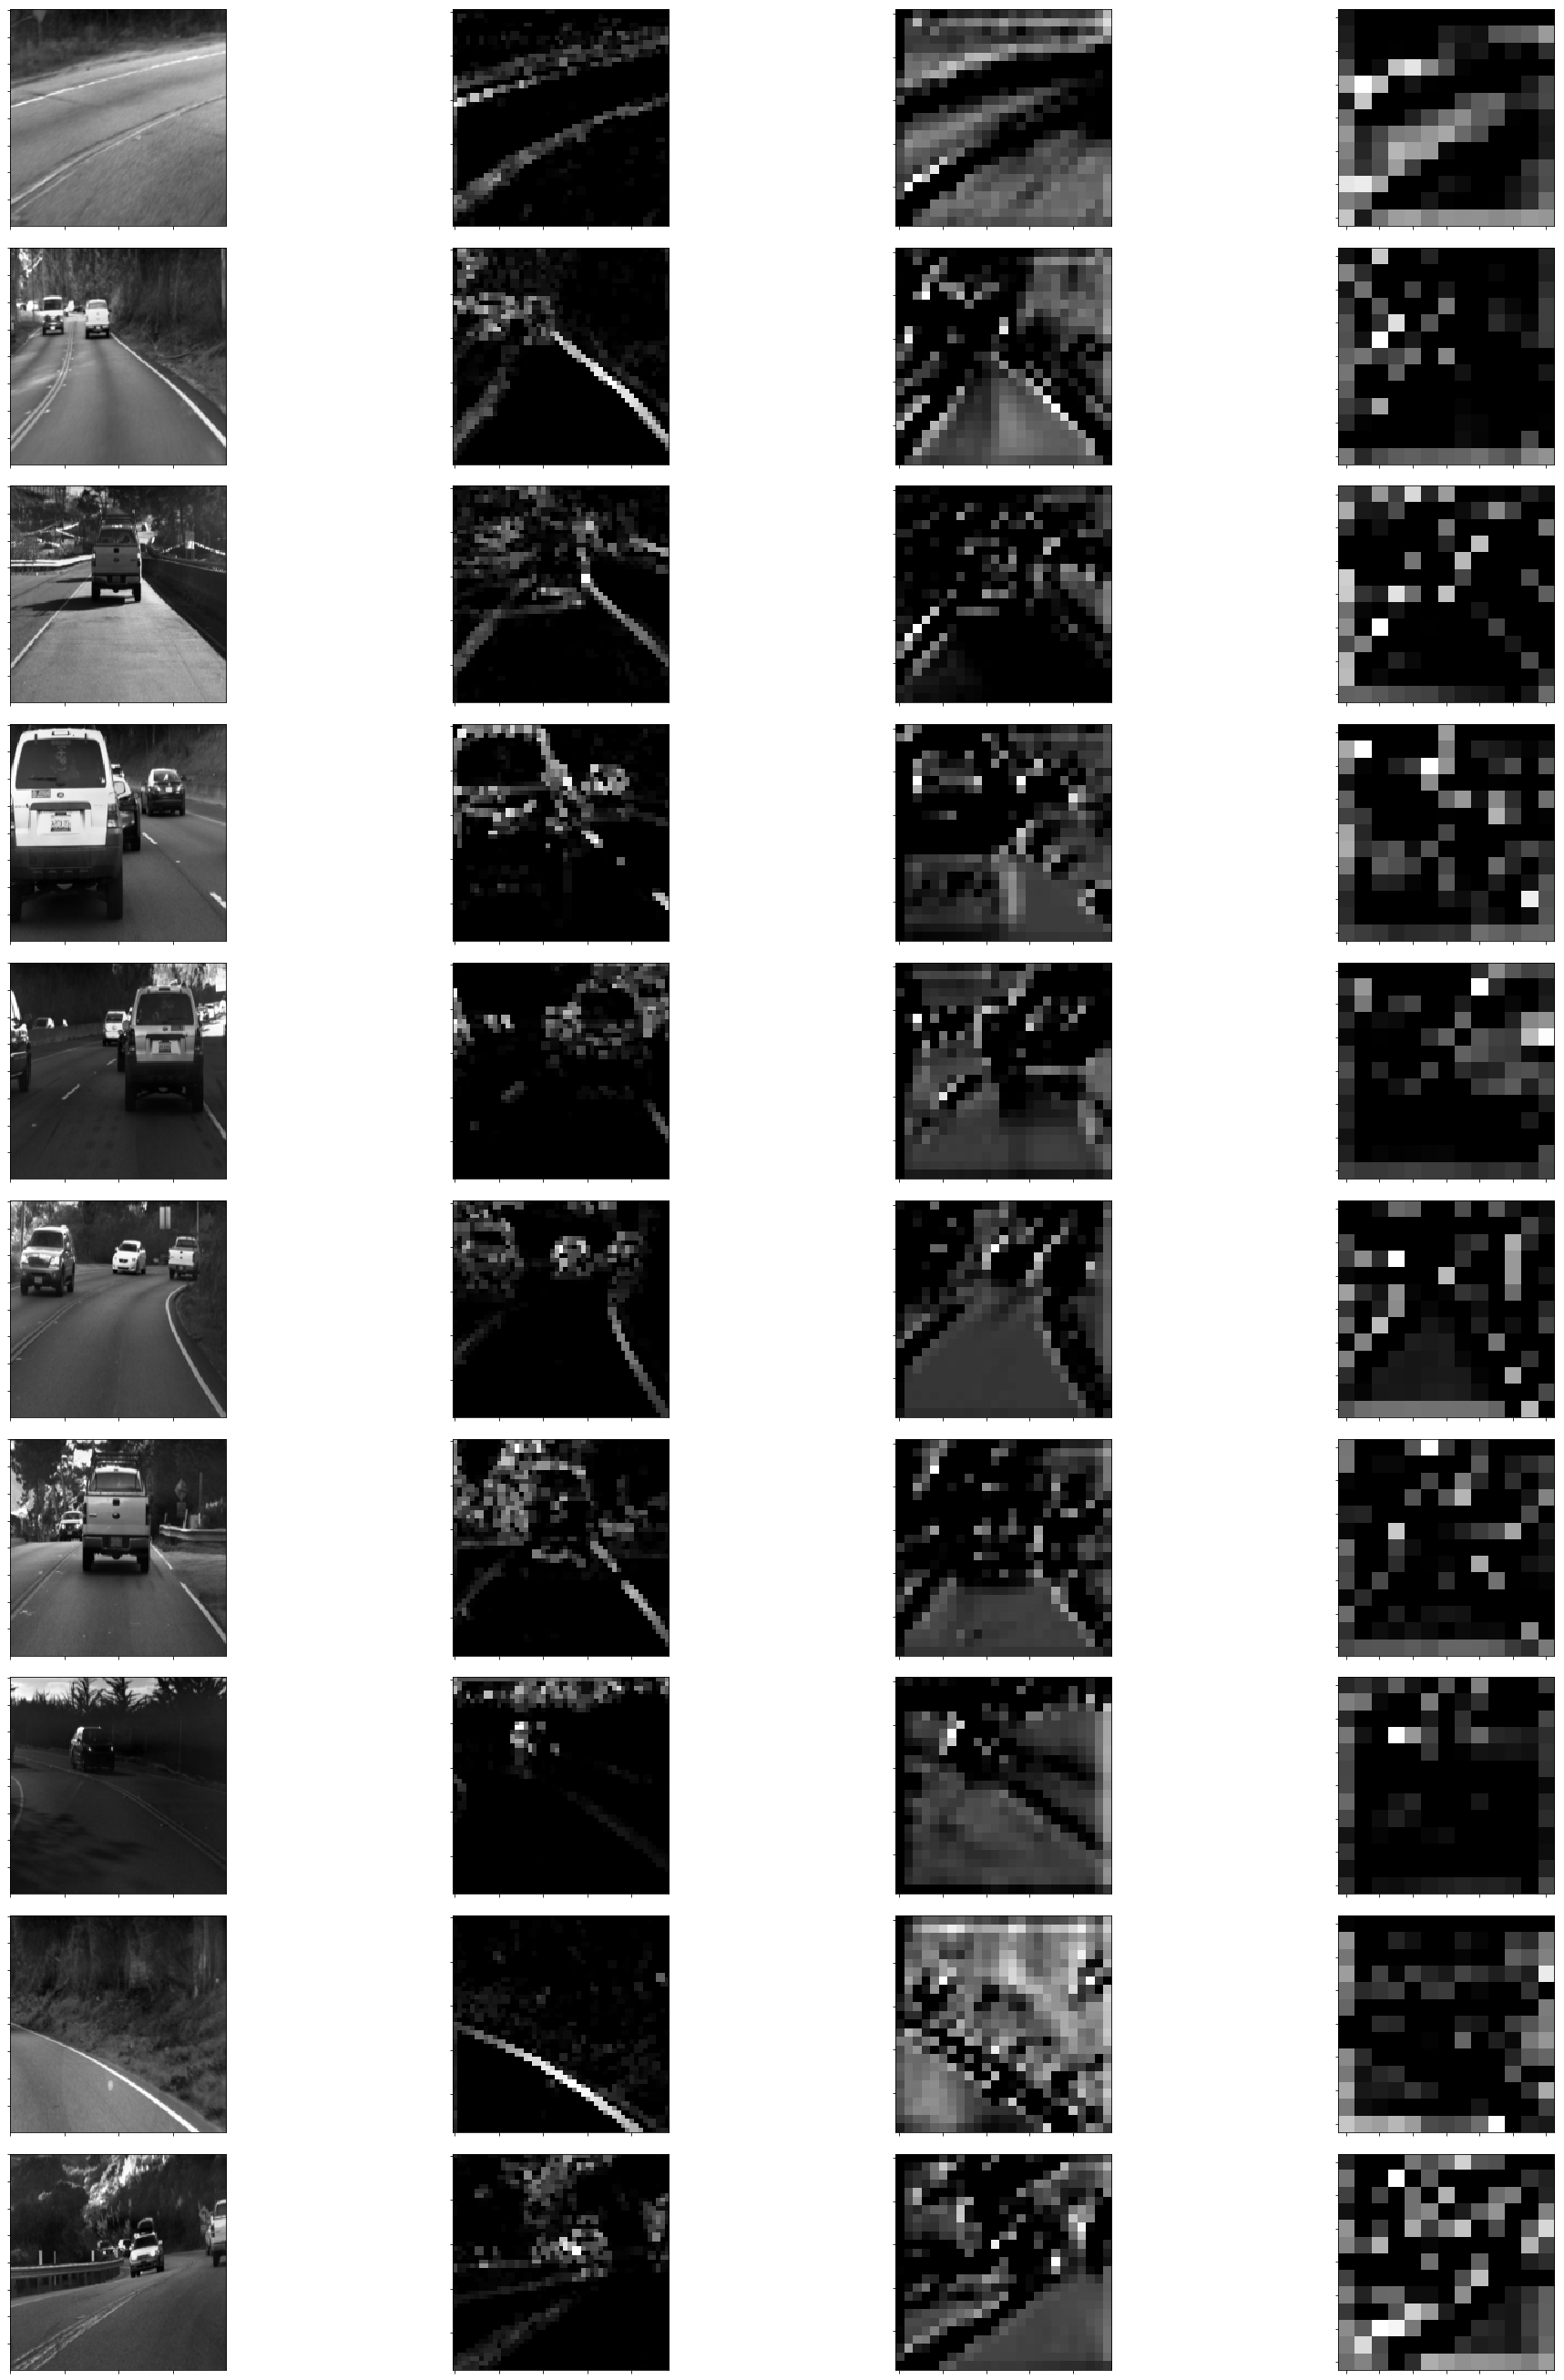

In [29]:
if test_model == "s1p5":
    nrow = 10
    ncol = 4

    fig = plt.figure(figsize=(40, 40))

    gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1, 1],
             wspace=0., hspace=0.1, top=0.95, bottom=0.05, left=0.17, right=0.845)

    for row in range(nrow):
        for col in range(ncol):
            ax= plt.subplot(gs[row, col])
            if col == 0:
                im = X_vis[row, ...].squeeze()
                ax.imshow(im, cmap='gray')
            else:
                feature_map = intermediate_output[col-1][row, ...]
                ax.imshow(feature_map[:, :, 0], cmap='gray')
            ax.set_xticklabels([])
            ax.set_yticklabels([])

    plt.savefig("./images/layers_activation.png")
    plt.show()

# 4. Confusion matrix

In [30]:
if test_model == "s1p1":
    y_val_1 = np.argmax(y_val, axis=1)
    y_hat_1 = np.argmax(y_hat, axis=1)
if test_model == "s1p5":
    # Convert 1st prediction into class ID
    y_val_1 = np.argmax(y_val[0], axis=1)
    y_hat_1 = np.argmax(y_hat[0], axis=1)

In [31]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        norm_factor = cm.sum(axis=1)[:, np.newaxis]
        norm_factor[norm_factor == 0] = 1
        cm = cm.astype('float') / norm_factor
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(50,50))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


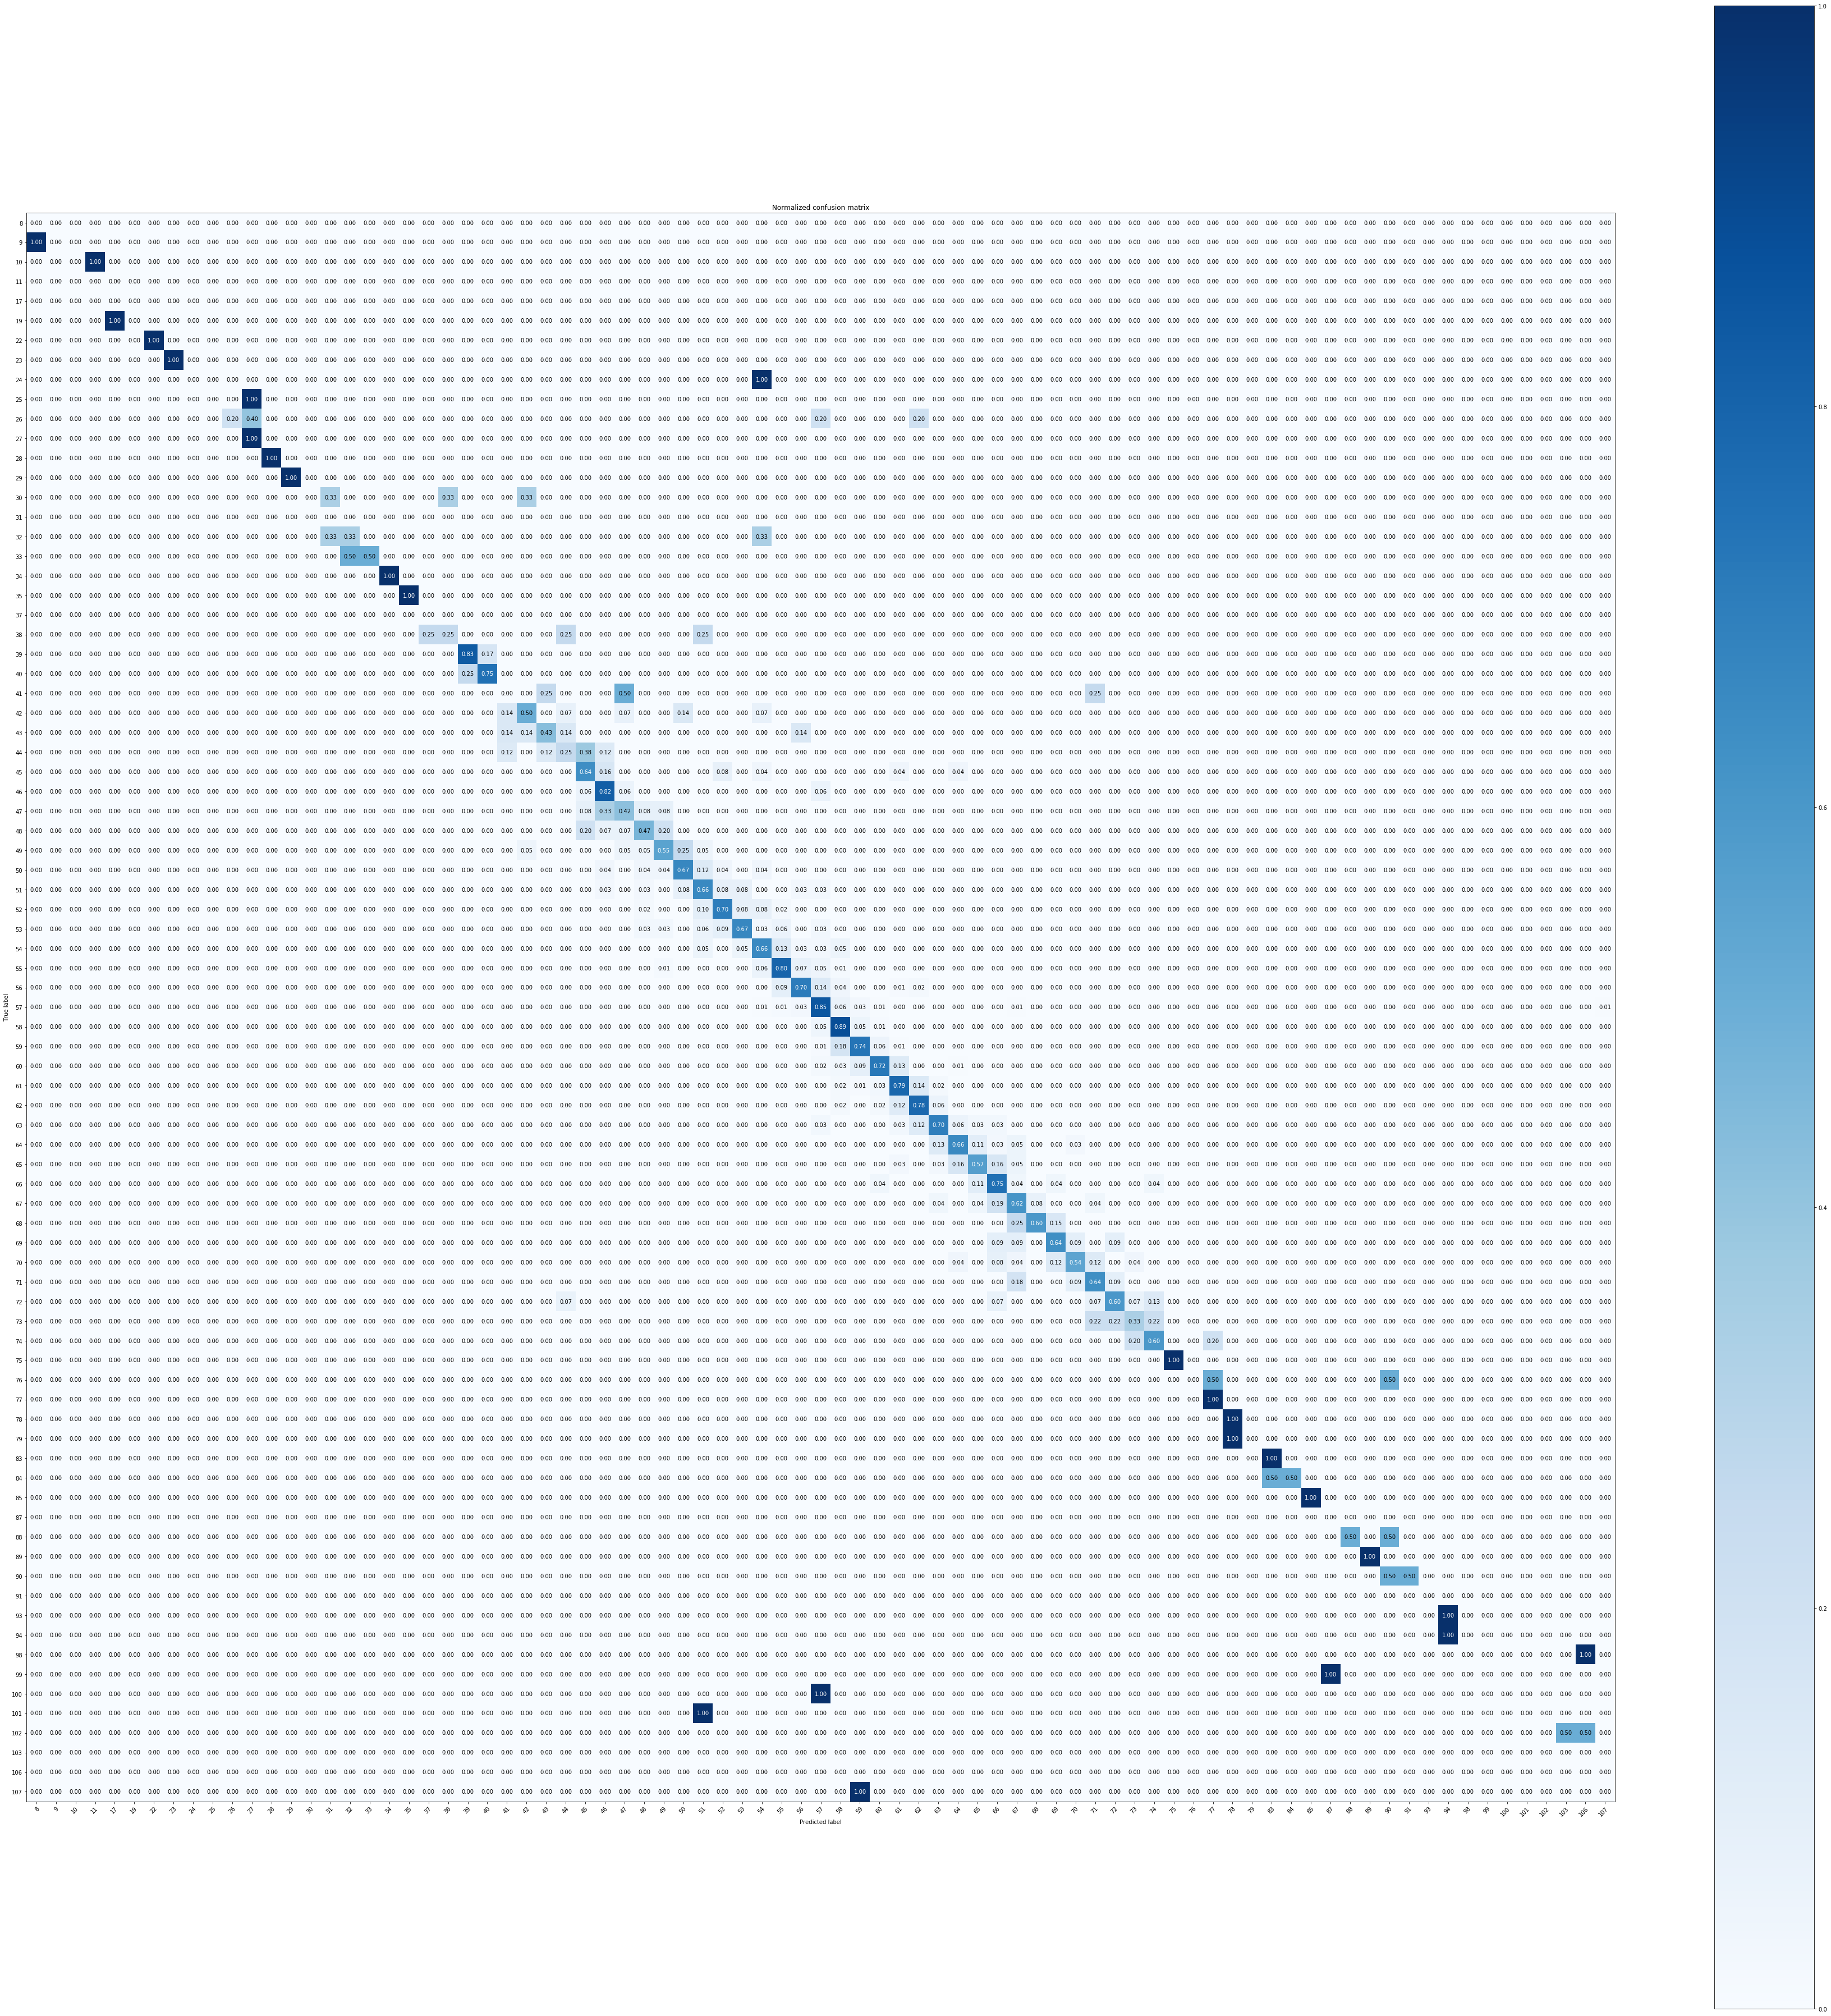

In [32]:
class_names = np.array([str(i) for i in range(114)])
plot_confusion_matrix(y_val_1, y_hat_1, class_names, normalize=True)
plt.savefig("./images/unnorm_confusion_matrix.png")